In [3]:
# phrase 1
import pandas as pd

# Load data
df = pd.read_csv("Food_Delivery_Time_Prediction2.csv")
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [ ]:

# Handle missing values through imputation.
# Check for missing values
print(df.isnull().sum())

# Fill missing numeric values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical missing values with mode
for col in df.select_dtypes(include='object'):
    df[col].fillna(df[col].mode()[0], inplace=True)

Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


C:\Users\tanis\AppData\Local\Temp\ipykernel_3852\200416542.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [5]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Order_Time', 'Vehicle_Type']
le = LabelEncoder()

for col in label_cols:
    df[col] = le.fit_transform(df[col])

In [6]:
# Normalize numeric continuous features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [7]:
# feature engineering
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    a = np.sin(d_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(d_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Extract coordinates
df['Customer_Lat'] = df['Customer_Location'].apply(lambda x: float(x.strip("()").split(',')[0]))
df['Customer_Long'] = df['Customer_Location'].apply(lambda x: float(x.strip("()").split(',')[1]))
df['Restaurant_Lat'] = df['Restaurant_Location'].apply(lambda x: float(x.strip("()").split(',')[0]))
df['Restaurant_Long'] = df['Restaurant_Location'].apply(lambda x: float(x.strip("()").split(',')[1]))

df['Geo_Distance'] = df.apply(lambda row: haversine(row['Customer_Lat'], row['Customer_Long'], row['Restaurant_Lat'], row['Restaurant_Long']), axis=1)

# Normalize the new distance
df['Geo_Distance'] = scaler.fit_transform(df[['Geo_Distance']])


In [9]:
threshold = df['Delivery_Time'].median()
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > threshold else 0)

In [15]:
# phrase 2
# classification
from sklearn.model_selection import train_test_split
X = df.drop(columns=['Order_ID','Delivery_Time', 'Delivery_Status', 'Customer_Location', 'Restaurant_Location'])
y = df['Delivery_Status']

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Model 1: Naive Bayes (Gaussian)
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_gnb))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gnb)) 

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.65      0.52      0.58        21

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40

Naive Bayes Confusion Matrix:
[[13  6]
 [10 11]]


In [17]:
# Model 2: K-Nearest Neighbors (KNN)
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.57      0.68      0.62        19
           1       0.65      0.52      0.58        21

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40

Confusion Matrix:
 [[13  6]
 [10 11]]


In [19]:
# Model 3: Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=5, min_samples_split=4)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree Report:\n", classification_report(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))


Decision Tree Report:
               precision    recall  f1-score   support

           0       0.54      0.68      0.60        19
           1       0.62      0.48      0.54        21

    accuracy                           0.57        40
   macro avg       0.58      0.58      0.57        40
weighted avg       0.59      0.57      0.57        40

Confusion Matrix:
 [[13  6]
 [11 10]]


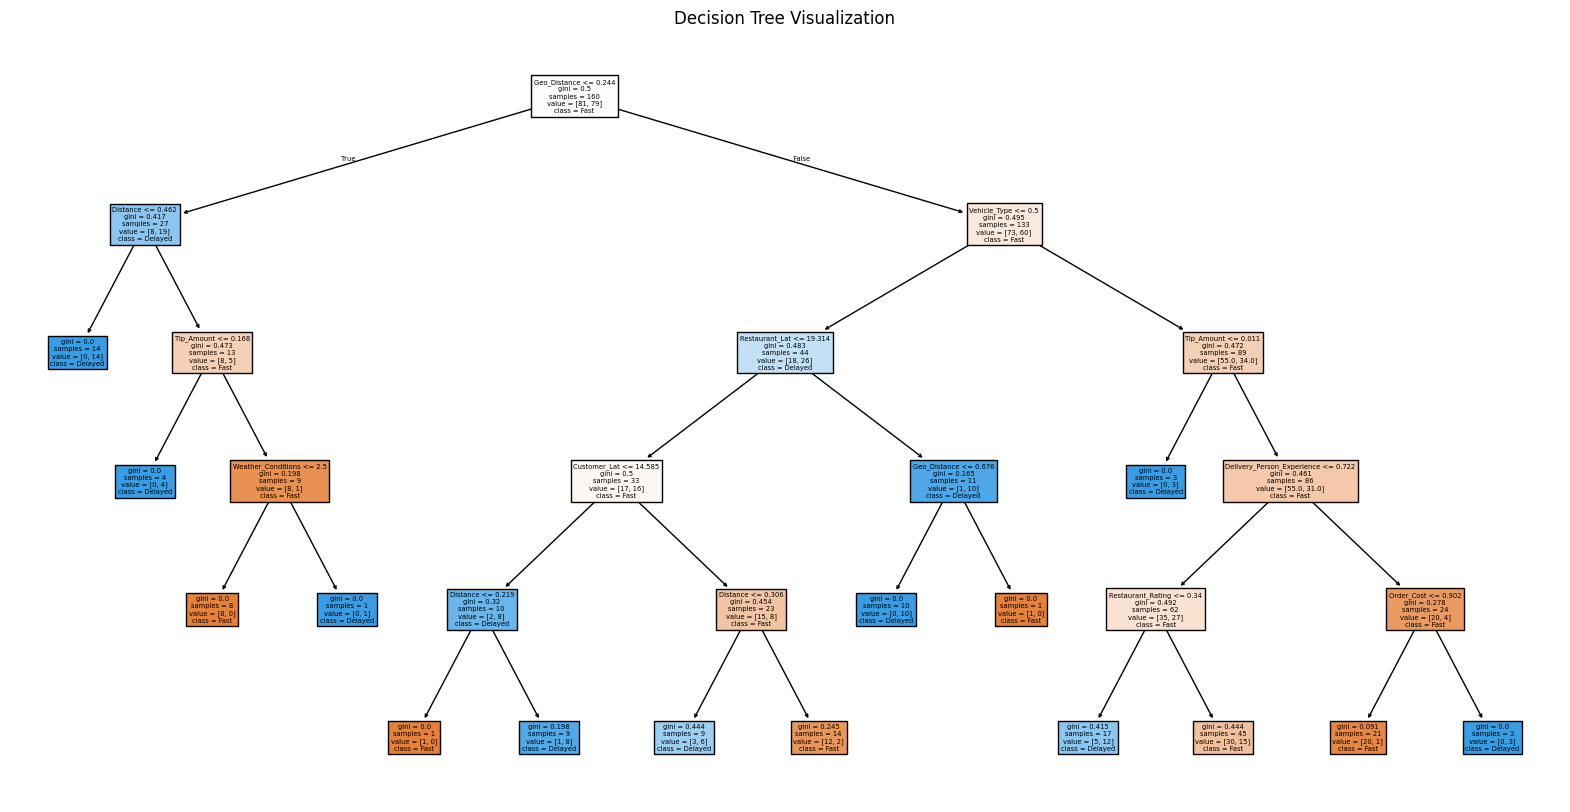

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, class_names=["Fast", "Delayed"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


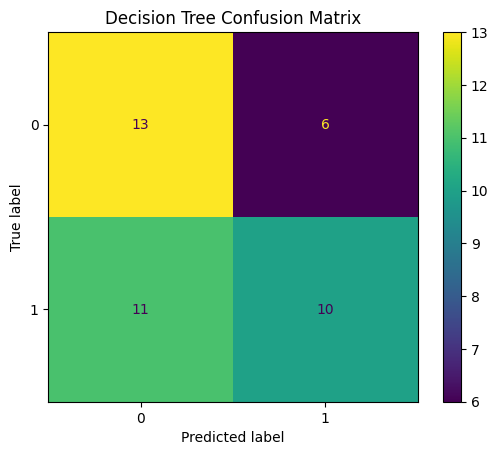

In [22]:
# hase 3: Reporting and Insights
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Example for Decision Tree
ConfusionMatrixDisplay.from_estimator(tree, X_test, y_test)
plt.title("Decision Tree Confusion Matrix")
plt.show()


In [ ]:
'''
The final submission includes a complete Jupyter Notebook containing the entire data pipeline—from preprocessing and feature engineering to model training and evaluation. This notebook demonstrates how missing values were handled, categorical variables were encoded, numerical features were normalized, and a binary target was created based on delivery time. Three classification models were implemented: Gaussian Naive Bayes, K-Nearest Neighbors (with hyperparameter tuning), and Decision Tree (with pruning). Each model was evaluated using metrics such as accuracy, precision, recall, and F1-score. Visual outputs like confusion matrices and a visualized decision tree are embedded in the notebook to support model interpretation. In addition, a summary report is provided, highlighting the most effective model, key insights drawn from the results, and final recommendations for choosing the most appropriate classifier based on accuracy, efficiency, and interpretability.
''' 

'\nThe final submission includes a complete Jupyter Notebook containing the entire data pipeline—from preprocessing and feature engineering to model training and evaluation. This notebook demonstrates how missing values were handled, categorical variables were encoded, numerical features were normalized, and a binary target was created based on delivery time. Three classification models were implemented: Gaussian Naive Bayes, K-Nearest Neighbors (with hyperparameter tuning), and Decision Tree (with pruning). Each model was evaluated using metrics such as accuracy, precision, recall, and F1-score. Visual outputs like confusion matrices and a visualized decision tree are embedded in the notebook to support model interpretation. In addition, a summary report is provided, highlighting the most effective model, key insights drawn from the results, and final recommendations for choosing the most appropriate classifier based on accuracy, efficiency, and interpretability.\n'